# SMAI Assignment - 4

## $\color{gold}{\text{Mini-Project: Age Prediction}}$

In [1]:
# Helpful preamble commands and imports for Jupyter notebooks 

# reload notebook automatically after changes to source python files
%load_ext autoreload
%autoreload 2

# standard libraries
from pathlib import Path
import json
from glob import glob
from os.path import join
from pathlib import Path
from tqdm import tqdm
import shutil

# scientific computing
import math
import numpy as np
import pandas as pd
from PIL import Image

# visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
%matplotlib inline

In [2]:
import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# setting random seed for reproducibility
RANDOM_SEED = 24
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

KAGGLE = False
if KAGGLE:
    DATA_PATH = Path('/kaggle/input/smai-24-age-prediction/content/faces_dataset/')
else:
    DATA_PATH = Path('data/')

train_path = DATA_PATH / 'train_aug_4'
train_ann_path = DATA_PATH / 'train_aug_4.csv'

test_path = DATA_PATH / 'test'
test_ann_path = DATA_PATH / 'submission.csv'

In [3]:
class AgeDataset(torch.utils.data.Dataset):

    def __init__(self, data_path, annot_path, train=True):
        super(AgeDataset, self).__init__()

        self.annot_path = annot_path
        self.data_path = data_path
        self.train = train
        
        self.ann = pd.read_csv(annot_path)
        self.files = self.ann['file_id']
        if train:
            self.ages = self.ann['age']
        self.transform = self._transform(224)

    @staticmethod    
    def _convert_image_to_rgb(image):
        return image.convert("RGB")

    def _transform(self, n_px):
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        return Compose([
            Resize(n_px),
            self._convert_image_to_rgb,
            ToTensor(),
            Normalize(mean, std),
        ])

    def read_img(self, file_name):
        im_path = join(self.data_path,file_name)   
        img = Image.open(im_path)
        img = self.transform(img)
        return img

    def __getitem__(self, index):
        file_name = self.files[index]
        img = self.read_img(file_name)
        if self.train:
            age = self.ages[index]    
            return img, age
        else:
            return img

    def __len__(self):
        return len(self.files)

train_dataset = AgeDataset(train_path, train_ann_path, train=True)
test_dataset = AgeDataset(test_path, test_ann_path, train=False)

In [4]:
from torch.utils.data import random_split

val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# printing the number of training and test examples
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(val_dataset)}")
print(f"Number of test examples: {len(test_dataset)}")

Number of training examples: 24468
Number of validation examples: 6116
Number of test examples: 1950


In [5]:
def analyze_dataset(dataset, title="Dataset Analysis"):
    ages = [sample[1] for sample in dataset]

    # Plot distribution of ages
    plt.figure(figsize=(10, 6))
    plt.hist(ages, bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of Ages ({title})")
    plt.xlabel("Age")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Calculate basic statistics
    mean_age = np.mean(ages)
    variance_age = np.var(ages)
    print(f"Mean Age: {mean_age}")
    print(f"Variance of Age: {variance_age}")

    # Calculate mean and variance per age bin
    age_bins = np.linspace(min(ages), max(ages), num=10)
    mean_per_bin = []
    variance_per_bin = []
    for i in range(len(age_bins) - 1):
        bin_samples = [age for age in ages if age >= age_bins[i] and age < age_bins[i + 1]]
        mean_per_bin.append(np.mean(bin_samples))
        variance_per_bin.append(np.var(bin_samples))

    # Plot mean and variance per age bin
    plt.figure(figsize=(10, 6))
    plt.errorbar(age_bins[:-1], mean_per_bin, yerr=np.sqrt(variance_per_bin), fmt='o', color='green')
    plt.title(f"Mean and Variance per Age Bin ({title})")
    plt.xlabel("Age")
    plt.ylabel("Mean")
    plt.grid(True)
    plt.show()

    print("Mean and Variance per Age Bin:")
    for i in range(len(age_bins) - 1):
        print(f"Age Bin {i+1}: Mean - {mean_per_bin[i]}, Variance - {variance_per_bin[i]}")

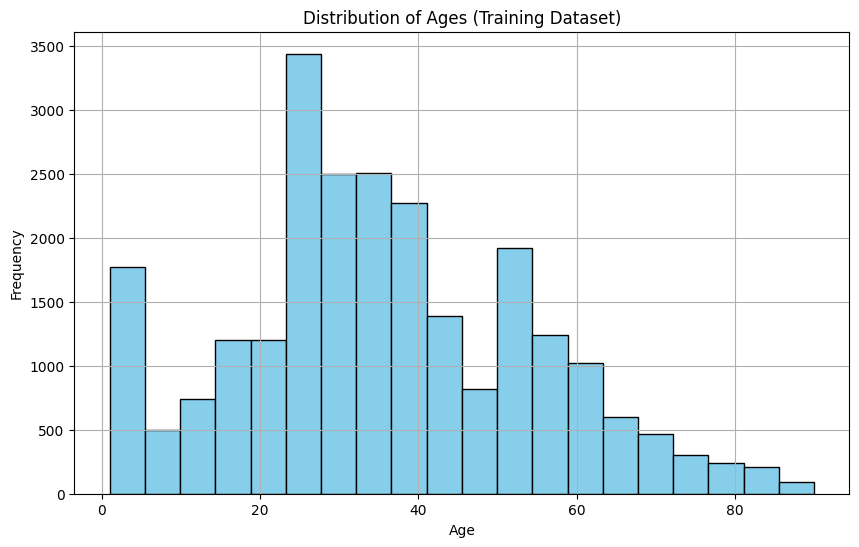

Mean Age: 35.729360797776685
Variance of Age: 354.9843807096158


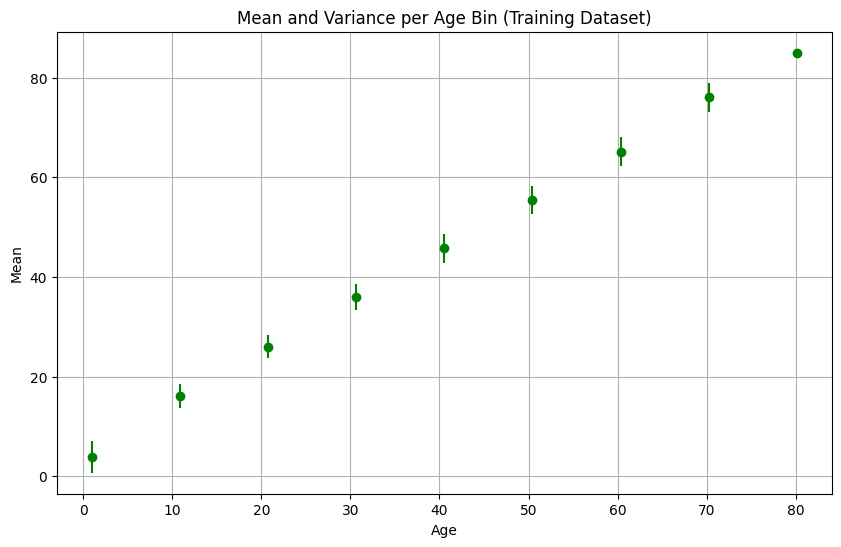

Mean and Variance per Age Bin:
Age Bin 1: Mean - 3.864187550525465, Variance - 9.864335900152206
Age Bin 2: Mean - 16.08878048780488, Variance - 5.9160204640095175
Age Bin 3: Mean - 26.021094264996705, Variance - 5.616891881028415
Age Bin 4: Mean - 36.03789004457652, Variance - 6.829545028028675
Age Bin 5: Mean - 45.806286299965834, Variance - 8.51286789616694
Age Bin 6: Mean - 55.439133205863605, Variance - 7.557321364665375
Age Bin 7: Mean - 65.12839673913044, Variance - 8.743704494771977
Age Bin 8: Mean - 76.06009244992296, Variance - 8.321504459865956
Age Bin 9: Mean - 85.0, Variance - 0.0


In [6]:
analyze_dataset(train_dataset, title="Training Dataset")